# RANDOM FOREST MODELS

this script fits a random forest model to the data, determines the relative importance of different variables, prunes the models accordingly, makes predictions based on the model, and describes the relationships between AT and admits

libraries

In [1]:
library(zoo)
library(ggplot2)
library(reshape)
library(lattice)
library(data.table)
library(randomForest)
library(rpart.plot)
library(vita)
library(tidyverse)


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'data.table'

The following object is masked from 'package:reshape':

    melt

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Loading required package: rpart
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------
Conflicts with tidy packages ---------------------------------------------------
between():   dplyr, data.table
combine():   dplyr, randomForest
expand():    tidyr, reshape
filter():    dplyr, stats
lag():       dplyr, stats
l

data prep

In [12]:
## open files ##
data_path = "F:/Users/Jason/Desktop/Health_data/DLNMs/data_files"

dane_admits = read_csv(paste(data_path,"admissions_daily_countywide.csv",sep="/"))
zip_temps = read_csv(paste(data_path,"temperatures_ZCTA_daily.csv",sep="/"))
zip_admits = read_csv(paste(data_path,"admissions_daily_ZCTA.csv",sep="/"))
zip_census = read_csv(paste(data_path,"census_ZCTA.csv",sep="/"))
AQ = read_csv(paste(data_path,"AQ_data.csv",sep="/"))

## prep zip_df ##
zip_temps = merge(zip_temps, AQ, by="DATE", all.x=T)
zip_df = merge(zip_admits, zip_temps, by=c("DATE","ZIP"), all.x=T)
zip_df = merge(zip_df, zip_census, by="ZIP", all.x=T)
zip_df$DATE = as.Date(zip_df$DATE, format="%m-%d-%y")
zip_df = zip_df[order(zip_df$DATE),]
zip_df$DOW = weekdays(zip_df$DATE)
zip_df$DOY = as.integer(strftime(zip_df$DATE, format = "%j"))
zip_df$WEEK = (zip_df$DOY-1)%/%7 + 1
zip_df$MONTH = as.integer(strftime(zip_df$DATE, format = "%m")) 
zip_df$YEAR = as.integer(strftime(zip_df$DATE, format = "%y"))
zip_df$WEEKEND = ifelse(zip_df$DOW == "Saturday" | zip_df$DOW == "Sunday", 1, 0)

## population weighted ATs for countywide analysis ##
w1 = zip_df
w1$wATMAX = w1$ATMAX*w1$POP/sum(zip_census$POP)
w1$wATMIN = w1$ATMIN*w1$POP/sum(zip_census$POP)
dane_temps <- aggregate(c(w1["wATMAX"],w1["wATMIN"]), by=w1[c("DATE")], FUN=sum, na.rm=T)
colnames(dane_temps) = c("DATE","ATMAX","ATMIN")

## prep dane_df
dane_admits$DATE = as.Date(dane_admits$DATE, format="%m-%d-%y")
AQ$DATE = as.Date(AQ$DATE, format="%m-%d-%y")
dane_temps = merge(dane_temps, AQ, by="DATE", all.x=T)
dane_df = merge(dane_admits, dane_temps, by="DATE", all.x=T)
dane_df = dane_df[order(dane_df$DATE),]
dane_df$DOW = weekdays(dane_df$DATE)
dane_df$DOY = as.integer(strftime(dane_df$DATE, format = "%j"))
dane_df$WEEK = (dane_df$DOY-1)%/%7 + 1
dane_df$MONTH = as.integer(strftime(dane_df$DATE, format = "%m")) 
dane_df$YEAR = as.integer(strftime(dane_df$DATE, format = "%y"))
dane_df$WEEKEND = ifelse(dane_df$DOW == "Saturday" | dane_df$DOW == "Sunday", 1, 0)
dane_df$obsno = seq(1,nrow(dane_df),1)
dane_df$prev_1_ATMAX = c(NA, head(dane_df['ATMAX'], dim(dane_df)[1] - 1)[[1]])
dane_df$prev_2_ATMAX = rollmean(dane_df$ATMAX,2,fill=NA,align='right')
dane_df$prev_3_ATMAX = rollmean(dane_df$ATMAX,3,fill=NA,align='right')
dane_df$prev_1_ATMIN = c(NA, head(dane_df['ATMIN'], dim(dane_df)[1] - 1)[[1]])
dane_df$prev_2_ATMIN = rollmean(dane_df$ATMIN,2,fill=NA,align='right')
dane_df$prev_3_ATMIN = rollmean(dane_df$ATMIN,3,fill=NA,align='right')

dane_df = subset(dane_df, MONTH!=4)
zip_df = subset(zip_df, MONTH!=4)
obsno = data.frame(dane_df[,c("DATE","obsno")])
zip_df = merge(zip_df,obsno,by="DATE")

Parsed with column specification:
cols(
  DATE = col_character(),
  ADMITS = col_integer()
)
Parsed with column specification:
cols(
  DATE = col_character(),
  ZIP = col_integer(),
  ATMAX = col_double(),
  ATMIN = col_double()
)
Parsed with column specification:
cols(
  ZIP = col_integer(),
  DATE = col_character(),
  ADMITS = col_integer(),
  EXPECTED = col_integer()
)
Parsed with column specification:
cols(
  .default = col_double(),
  ID = col_integer(),
  ZIP = col_integer(),
  AWATER10 = col_integer(),
  ALAND10 = col_integer(),
  GEOID10 = col_integer(),
  POP = col_integer(),
  PERCAPINC = col_integer(),
  MANY_STUDE = col_integer(),
  MEDIAN_INC = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  DATE = col_character(),
  O3 = col_double(),
  PM25 = col_double()
)


# AGGREGATE COUNTYWIDE MODEL

for aggregate daily Dane County admits, define training and test data, fit model, and print initial importance values


Call:
 randomForest(formula = ADMITS ~ ATMAX + DOW + MONTH + O3 + PM25,      data = training, importance = TRUE, ntree = 1000) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 1

          Mean of squared residuals: 633.7098
                    % Var explained: 36.16

,values
ATMAX,29.96
DOW,74.92
MONTH,16.09
O3,8.06
PM25,5.09


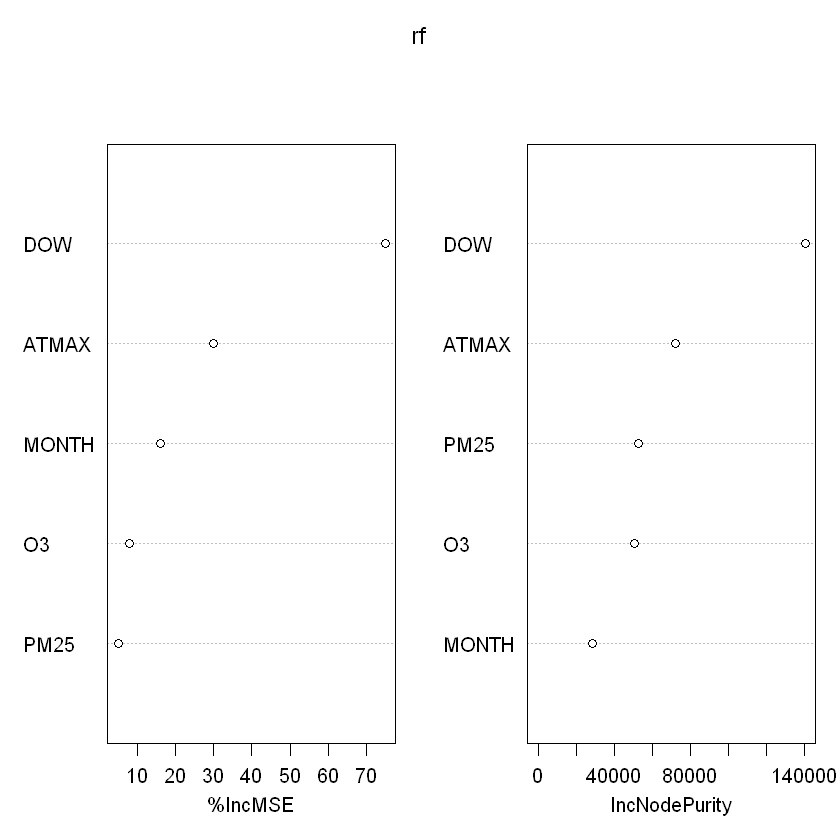

In [14]:
dane_df$DOW = as.factor(dane_df$DOW)
dane_df$MONTH = as.factor(dane_df$MONTH)
training = dane_df[sample(nrow(dane_df), nrow(dane_df)*0.75),]   ## 75% of data
test = dane_df[!(dane_df$DATE %in% training$DATE),]

rf=randomForest(ADMITS ~ ATMAX + DOW + MONTH + O3 + PM25, data=training, importance=TRUE, ntree = 1000)
rf
importance1 = data.frame(values=round(importance(rf), 2)[,1]); importance1
varImpPlot(rf)

permutation variable importance measures (PIMP), which can account for correlated variables when calculating importance values

In [16]:
Xs = training[,c("ATMAX","O3","PM25","DOW","MONTH")]
Ys = training[,c("ADMITS")]

pimp.varImp.reg<-PIMP(Xs,Ys,rf,S=100, ncores=3)
pimp.t.reg = PimpTest(pimp.varImp.reg, pless = 0.1)
summary(pimp.t.reg)

Call:
PimpTest.default(Pimp = pimp.varImp.reg, pless = 0.1)

PIMP.default(X = Xs, y = Ys, rForest = rf, S = 100, ncores = 3)
type:  [1] "regression"



  p-values less than  0.05 :
 ----------------------
      VarImp   p-value    
ATMAX 155.05 < 2.2e-16 ***
DOW   502.37 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

plot predicted vs observed using the test dataset (and print corr and rmse)

[1] "RMSE: 0.064"
[1] "CORR: 0.569"


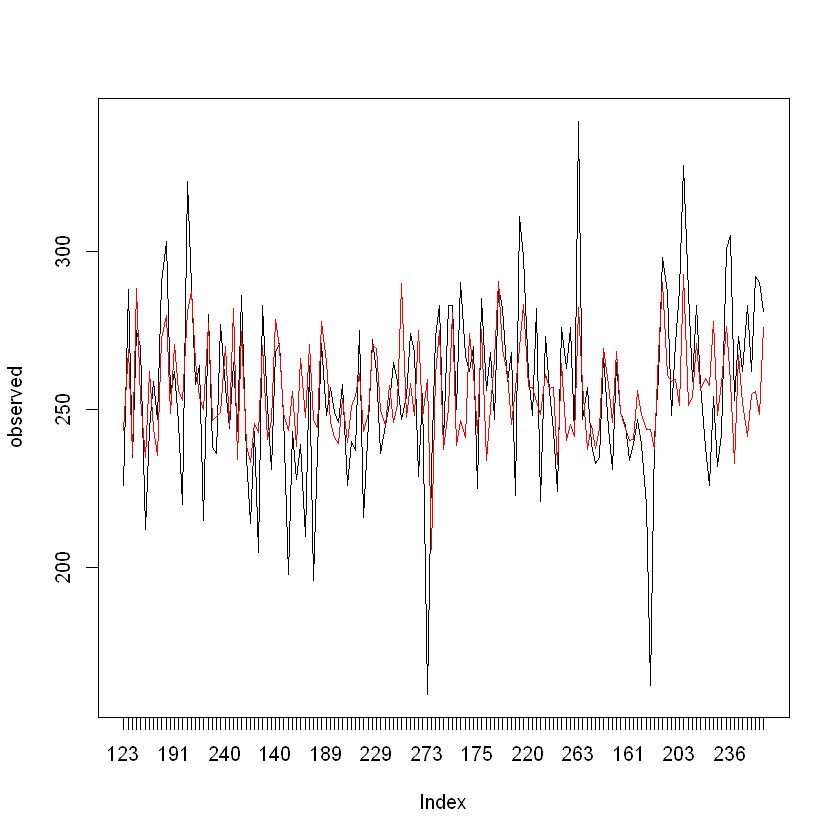

In [18]:
predicted = predict(rf, test)
observed = test$ADMITS

rmse1 = round(sqrt(mean(predicted-observed)^2),3); print(paste("RMSE:",rmse1))
correlation1 = round(cor(predicted,observed),3); print(paste("CORR:",correlation1))

plot(observed,type='l',ylim=range(predicted,observed),xaxt='n')
axis(1, at=1:nrow(test), labels=test$DOY)
lines(predicted,col='red')

partial plots of correlation between variables and admits (accounting for other variables)

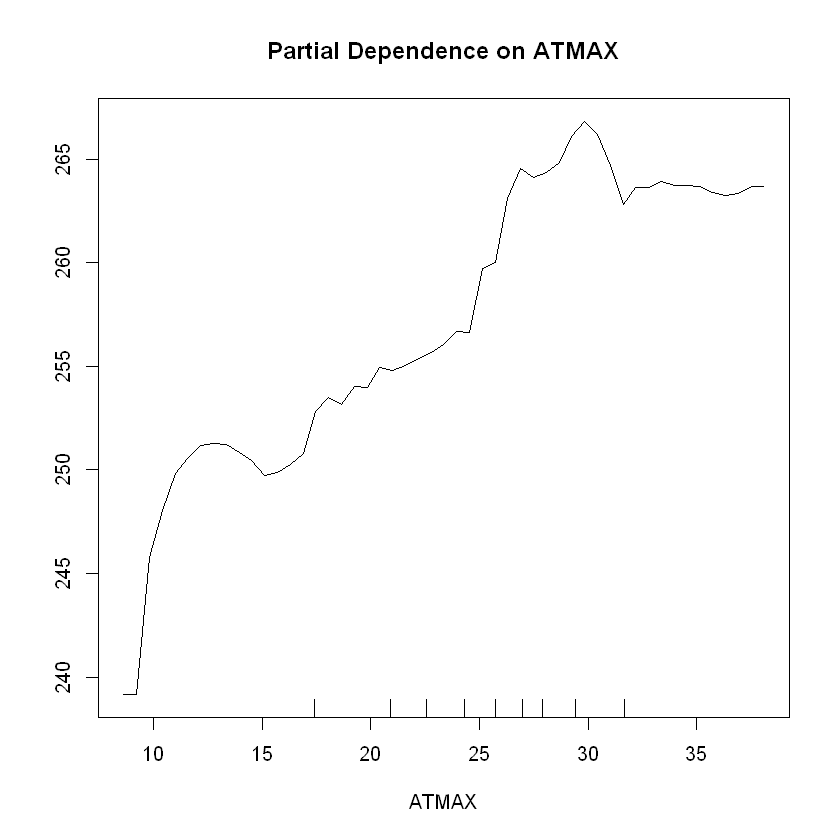

In [22]:
partialPlot(rf, training, ATMAX)

# ALL DATA MODEL

same as above, but for all zip-days


Call:
 randomForest(formula = ADMITS2 ~ ATMAX + DOW + MONTH + POVER70 +      PNONWHITE + PDISABLED + PPOV + PHIGHSCHOO + MEDAGE + MEDIAN_INC,      data = training, importance = TRUE, ntree = 200) 
               Type of random forest: regression
                     Number of trees: 200
No. of variables tried at each split: 3

          Mean of squared residuals: 544.2869
                    % Var explained: 48.47

,values
ATMAX,8.52
DOW,16.92
MONTH,8.10
POVER70,13.57
PNONWHITE,21.51
PDISABLED,17.87
PPOV,12.75
PHIGHSCHOO,17.83
MEDAGE,13.74
MEDIAN_INC,10.30


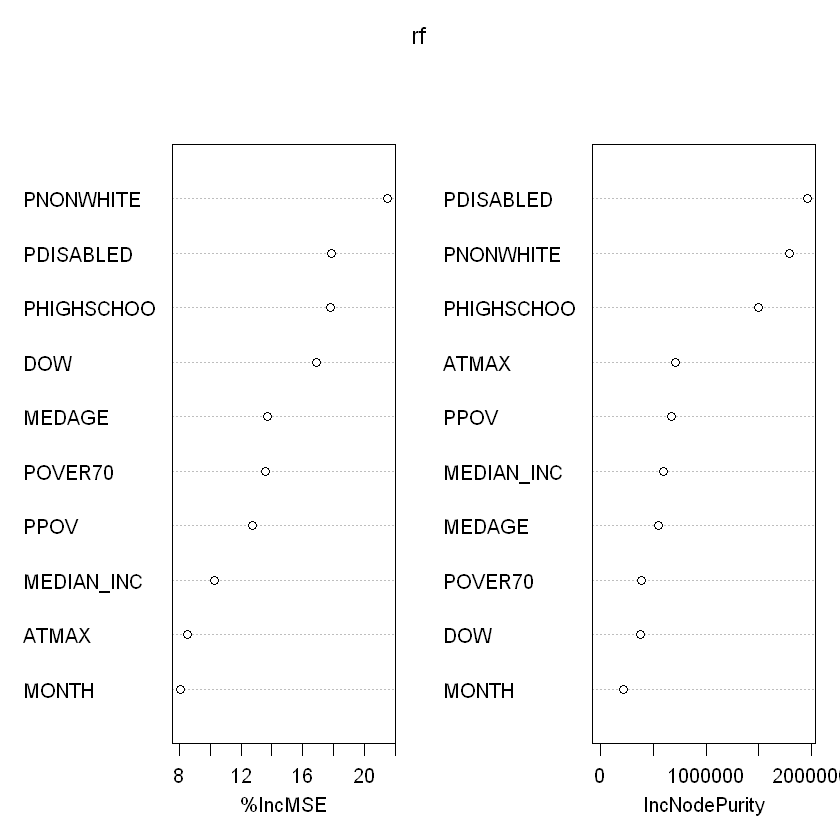

In [10]:
zip_df$DATE_ZIP = paste(zip_df$DATE,zip_df$ZIP)
zip_df$ADMITS2 = zip_df$ADMITS / zip_df$POP * 100000   #admits per day per 100,000
zip_df$DOW = as.factor(zip_df$DOW)
zip_df$MONTH = as.factor(zip_df$MONTH)
zip_df = zip_df[!is.na(zip_df$ADMITS2),]
training = zip_df[sample(nrow(zip_df), nrow(zip_df)*0.8),]
test = zip_df[!(zip_df$DATE_ZIP %in% training$DATE_ZIP),]

rf=randomForest(ADMITS2 ~ ATMAX+DOW+MONTH+POVER70+PNONWHITE+PDISABLED+PPOV+PHIGHSCHOO+MEDAGE+MEDIAN_INC, data=training, importance=TRUE, ntree = 200)
rf
importance1 = data.frame(values=round(importance(rf), 2)[,1]); importance1
varImpPlot(rf)

permutation variable importance measures (PIMP), which can account for correlated variables when calculating importance values

In [ ]:
Xs = training[,c("ATMAX","DOW","MONTH","POVER70","PNONWHITE","PDISABLED","PPOV","PHIGHSCHOO","MEDAGE","MEDIAN_INC")]
Ys = training[,c("ADMITS2")]
pimp.varImp.reg<-PIMP(Xs,Ys,rf,S=100, ncores=3)
pimp.t.reg = PimpTest(pimp.varImp.reg, pless = 0.1)
summary(pimp.t.reg)

plot predicted vs observed using the test dataset (and print corr and rmse)

[1] "RMSE: 5.76833855304191e-06"
[1] "CORR: 0.705587670324933"


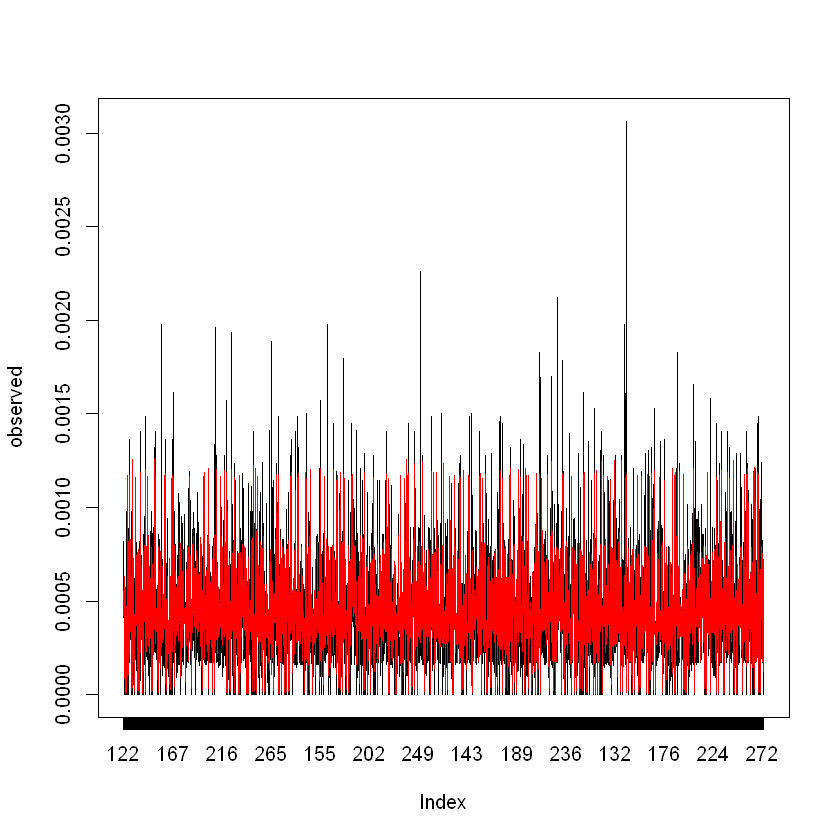

In [7]:
predicted = predict(rf, test)
observed = test$ADMITS2

rmse1 = sqrt(mean(predicted-observed)^2); print(paste("RMSE:",rmse1))
correlation1 = cor(predicted,observed); print(paste("CORR:",correlation1))

plot(observed,type='l',ylim=range(predicted,observed),xaxt='n')
axis(1, at=1:nrow(test), labels=test$DOY)
lines(predicted,col='red')

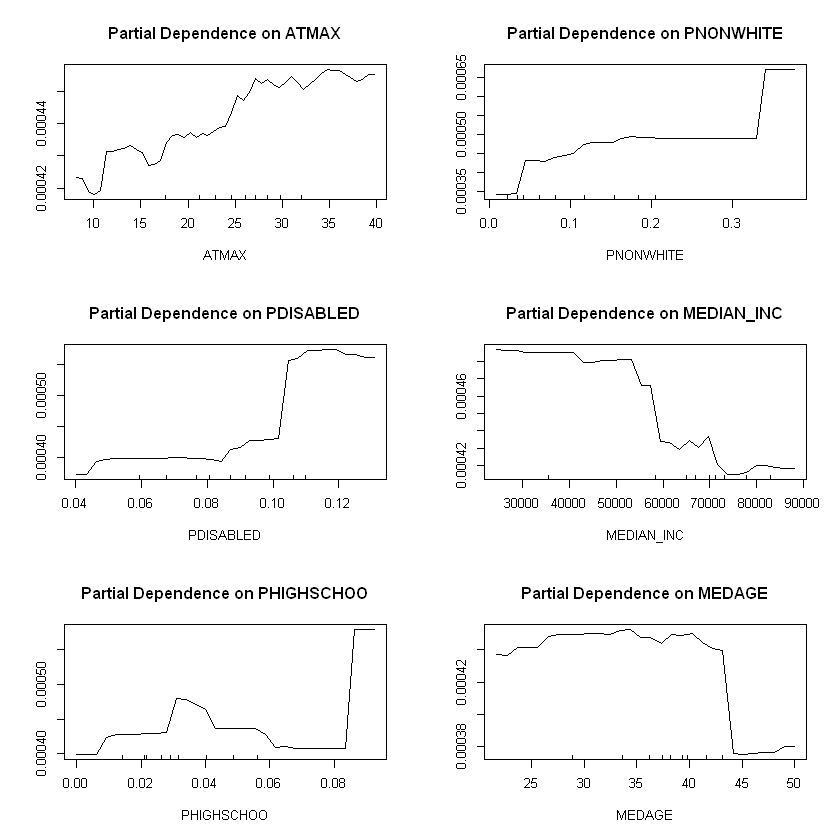

In [9]:
par(mfrow=c(3,2))
partialPlot(rf, training, ATMAX)
partialPlot(rf, training, PNONWHITE)
partialPlot(rf, training, PDISABLED)
partialPlot(rf, training, MEDIAN_INC)
partialPlot(rf, training, PHIGHSCHOO)
partialPlot(rf, training, MEDAGE)

# INDIVIDUAL ZIP RANDOM FORESTS